# Efecto de las medidas de bioseguridad respecto a la pandemia, estatus de los departamentos y estudio del efecto de las variables del comportamiento de Colombia sobre las variables epidemiologicas

In [3]:
# Herramientas de analisis
from matplotlib import pyplot as plt
from google.cloud import bigquery
from datetime import datetime,timedelta
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import seaborn as sns
import pandas as pd
import numpy as np
import os
from google.oauth2 import service_account

# Configuracion
%matplotlib inline
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 21})
DATE_FORMAT = "%Y-%m-%d"
obligated_quarantine = pd.to_datetime("2020-03-24")
selective_isolation = pd.to_datetime("2020-09-01")
credentials_dict = {
    'auth_provider_x509_cert_url': os.getenv('auth_provider_x509_cert_url'),
    'auth_uri': os.getenv("auth_uri"),
    'client_email': os.getenv("client_email"),
    'client_id':  os.getenv('client_id'),
    'client_x509_cert_url': os.getenv('client_x509_cert_url'),
    'private_key': os.getenv('private_key'),
    'private_key_id': os.getenv('private_key_id'),
    'project_id': os.getenv('project_id'),
    'token_url': os.getenv('token_url'),
    'type': os.getenv('type')
}

In [ ]:
credentials = service_account.Credentials.from_service_account_info(credentials_dict)

In [5]:
client = bigquery.Client(credentials=credentials, project=credentials_dict["project_id"])

In [6]:
query = ''' 
SELECT column_name, data_type, table_name
FROM `bigquery-public-data.covid19_open_data.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'covid19_open_data';
'''

In [7]:
# Datos disponibles
result = client.query(query).result().to_dataframe()
result[["column_name", "data_type"]]

,column_name,data_type
0,date,DATE
1,location_key,STRING
2,country_code,STRING
3,country_name,STRING
4,subregion1_code,STRING
5,subregion1_name,STRING
6,subregion2_code,STRING
7,subregion2_name,STRING
8,iso_3166_1_alpha_2,STRING
9,iso_3166_1_alpha_3,STRING


### Efecto de las medidas de bioseguridad respecto a la pandemia

In [8]:
query = '''
SELECT date,cumulative_confirmed
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE country_name = "Colombia" AND aggregation_level = 0
'''

In [9]:
samples = client.query(query).result().to_dataframe()

In [10]:
samples = samples[samples["cumulative_confirmed"] != 0].dropna()

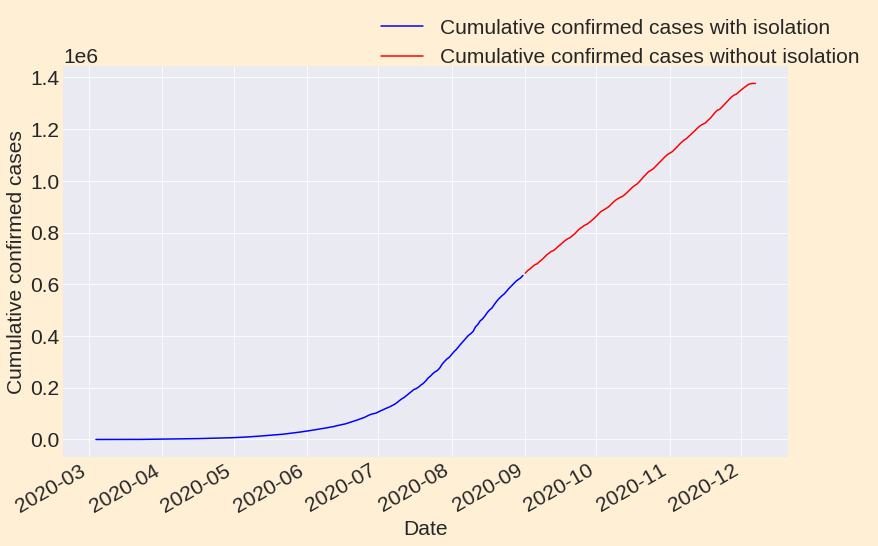

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(13)
fig.patch.set_facecolor("papayawhip")
ax.plot(samples[samples["date"] < selective_isolation]["date"], 
        samples[samples["date"] < selective_isolation]["cumulative_confirmed"],
        c = "blue", label = "Cumulative confirmed cases with isolation")
ax.plot(samples[samples["date"] >= selective_isolation]["date"], 
        samples[samples["date"] >= selective_isolation]["cumulative_confirmed"],
        c = "red", label = "Cumulative confirmed cases without isolation")
fig.autofmt_xdate()
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative confirmed cases")
fig.legend()
fig.show()
# Para iniciar el analisis se utilizara la conocida grafica de los casos acumulados en el tiempo
# en general no aporta mucha informacion, mas que decir que los casos van incrementando.
# Pero ¿Que pasaria si hacemos un modelo con estos datos?
# este comportamiento es tipo logistico y la ecuacion es conocida c / (1 + exp(-( x - b) / a)
# esto es debido a que la poblacion es un numero finito

In [12]:
class CaseLogisticModel:
    
    def __init__(self, country: str, case: str):
        self.country = country
        self.case = case
        self.data_case = pd.DataFrame()
        self.logistic_params_case = {"a": None, "b": None, "c": None}
        self.logistic_params_error_case = {"a_error": None, "b_error": None, "c_error": None}
        self.logistic_model = lambda x,a,b,c: c/(1 + np.exp(-(x-b)/a))
    
    def _clean_process(self, df: pd.DataFrame) -> pd.DataFrame:        
            df = df[["date",self.case]]
            df = df.dropna()
            df = df[df[self.case] > 0]
            return df
        
    def _transforming_dates(self, date_timestamp: pd._libs.tslibs.timestamps.Timestamp) -> int:
        return (datetime.strptime(str(date_timestamp), DATE_FORMAT) - \
                datetime.strptime(str(self.day_0), DATE_FORMAT)).days
    
    def _transforming_integers(self, day: int) -> pd._libs.tslibs.timestamps.Timestamp:
        first_day = datetime.strptime(str(self.day_0), DATE_FORMAT)
        current_day = first_day + timedelta(days=day)
        return datetime.date(current_day)
        
    def fit(self, df: pd.DataFrame,  p0_log: list = [50,20,4000000], 
            printing: bool = True) -> None:
        
        try:
            self.data_case = self._clean_process(df)
        except KeyError:
            raise KeyError("Please verify the study case is well specified")
            
            
        X = self.data_case["date"]
        self.day_0 = X.min()
        X = X.map(self._transforming_dates)        
        y = self.data_case[self.case]
        
        try:
            fit = curve_fit(self.logistic_model,X, y,p0 = p0_log, maxfev=2000)
        except Exception as error:
            print(f"Error {error} has happened, please check the parameters")
            return None
        
        errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
        a,b,c = fit[0]
        
        self.logistic_params_case = {
            key:value for key,value in zip(self.logistic_params_case.keys(),[a,b,c])
        }
        self.logistic_params_error_case = {
            key:value for key, value in zip(self.logistic_params_error_case.keys(),errors)
        }
        self._last_day_amount_of_case = self.logistic_params_case["c"]
        
        if printing:
            print(f"Logistic Model for {self.country} has been fited")
            print(f'''
                    Params and errors:
                    a = {self.logistic_params_case["a"]} +/- {self.logistic_params_error_case["a_error"]}
                    b = {self.logistic_params_case["b"]} +/- {self.logistic_params_error_case["b_error"]}
                    c = {self.logistic_params_case["c"]} +/- {self.logistic_params_error_case["c_error"]}
            ''')
        return None
        
    def predict_last_day(self) -> pd._libs.tslibs.timestamps.Timestamp:
        if self.logistic_params_case["a"] == None:
            print("Fit method must be used to predict last day")
            return None
        a = self.logistic_params_case["a"]
        b = self.logistic_params_case["b"]
        c = self.logistic_params_case["c"]
        last_day = int(fsolve(lambda x : self.logistic_model(x,a,b,c) - int(c),b))
        self.last_day = self._transforming_integers(last_day)
        return self.last_day
    
    def predict_last_day_amount_case(self) -> int:
        return int(self._last_day_amount_of_case)
    
    def _predict(self, day_as_int: int) -> int:
        a = self.logistic_params_case["a"]
        b = self.logistic_params_case["b"]
        c = self.logistic_params_case["c"]
        return int(self.logistic_model(day_as_int, a, b ,c))
        
    def get_behavior_until_a_date(self, date: str) -> pd.DataFrame:
        
        try:
            datetime.strptime(date, DATE_FORMAT)
        except ValueError:
            raise ValueError("Incorrect data format, it should be "+ DATE_FORMAT)
        
        if self.logistic_params_case["a"] == None:
            print("Fit method must be used to predict last day")
            return None
        
        date_as_int = self._transforming_dates(date)
        df = pd.DataFrame()
        df["int_dates"] = np.arange(date_as_int+1)
        df[self.case] = df["int_dates"].map(self._predict)
        df["date"] = df["int_dates"].map(self._transforming_integers)
        return df[["date",self.case]]
         
    def predict_given_a_date(self, date: str) -> int:  
        try:
            datetime.strptime(date, DATE_FORMAT)
        except ValueError:
            raise ValueError("Incorrect data format, it should be "+ DATE_FORMAT)
        
        if self.logistic_params_case["a"] == None:
            print("Fit method must be used to predict last day")
            return None
        
        date_as_int = self._transforming_dates(date)
        return self._predict(date_as_int)        

In [13]:
# Para entender mejor el fenomeno utilizaremos el modelo logistico 
# construido como la clase CaseLogisticModel.
# Esta fue diseñada de esta manera para evaluar el caso en el que se quiere representar
# y las variables puedan ser tanto casos acumulados como muertes acumuladas

#### Casos acumulados en el tiempo

In [14]:
# Modelo siguiendo el patron de cuarentena obligatoria
model_1 = CaseLogisticModel("Colombia", "cumulative_confirmed")
model_1.fit(samples.loc[(samples["date"] > obligated_quarantine) & 
                       (samples["date"] < selective_isolation)])

Logistic Model for Colombia has been fited

                    Params and errors:
                    a = 21.714610205176047 +/- 0.08797365872818484
                    b = 142.55009914946115 +/- 0.2851801316313018
                    c = 942139.5780706522 +/- 5820.656936997529
            


In [15]:
# Entre las preguntas de interes podriamos tener
# ¿Cuando aproximadamente habria sido el ultimo dia de infeccion
# si se hubiera seguido este regiment de cuarentena?
obligated_quarantine_last_day = model_1.predict_last_day()
print("Last day following obligated quarantine:")
print(obligated_quarantine_last_day)

Last day following obligated quarantine:
2021-06-21


In [16]:
# ¿Cuantas casos acumulados se hubrian tenido hasta ese momento?
obligated_quarantine_last_day_cumulative_confirmed = model_1.predict_last_day_amount_case()
print("cumulative_confirmed at last day following obligated quarantine:")
print(obligated_quarantine_last_day_cumulative_confirmed)
# Es necesario notar que la cantidad actual de casos
# ya es mucho mayor que esto, una clara demostracion
# de la importacia de la cuarentena.

cumulative_confirmed at last day following obligated quarantine:
942139


In [17]:
# Pero ahora que tenemos esto
# ¿Como pudo haber afectado el aislamiento selectivo a este comportamiento?
model_2 = CaseLogisticModel("Colombia", "cumulative_confirmed")
model_2.fit(samples)

Logistic Model for Colombia has been fited

                    Params and errors:
                    a = 33.97569096706473 +/- 0.5655529451479803
                    b = 192.44050275380363 +/- 0.9492352482751617
                    c = 1411849.7417387061 +/- 13660.48552138199
            


In [18]:
# ¿Ultimo dia de infeccion bajo este regimen?
selective_isolation_last_day = model_2.predict_last_day()
print("Last day following selective isolation:")
print(selective_isolation_last_day)
# Debemos recordar y mantener en mente
# que esto es solo un resultado basado en un modelo, el cual
# puede llegar a ser un poco especulativo pero se utiliza como referencia
# y poder tomar acciones respecto a la realidad.

Last day following selective isolation:
2022-01-16


In [19]:
# ¿Cual sera la cantidad de casos acumulados en el ultimo dia de infeccion bajo solo este regimen?
selective_isolation_last_day_cumulative_confirmed = model_2.predict_last_day_amount_case()
print("cumulative_confirmed at last day following selective isolation:")
print(selective_isolation_last_day_cumulative_confirmed)
# esta cifra es una cantidad de casos tambien especulativa
# pero podemos notar que esta muy por encima del primer comportamiento
# con cuarentena obligatoria

cumulative_confirmed at last day following selective isolation:
1411849


In [20]:
# Para ver el impacto utilizaremos unos graficos generando datos 
# con los modelos construidos, hasta el dia actual
current_date = str(samples["date"].max())
obligated_quarantine_data = model_1.get_behavior_until_a_date(current_date)
selective_isolation_data = model_2.get_behavior_until_a_date(current_date)

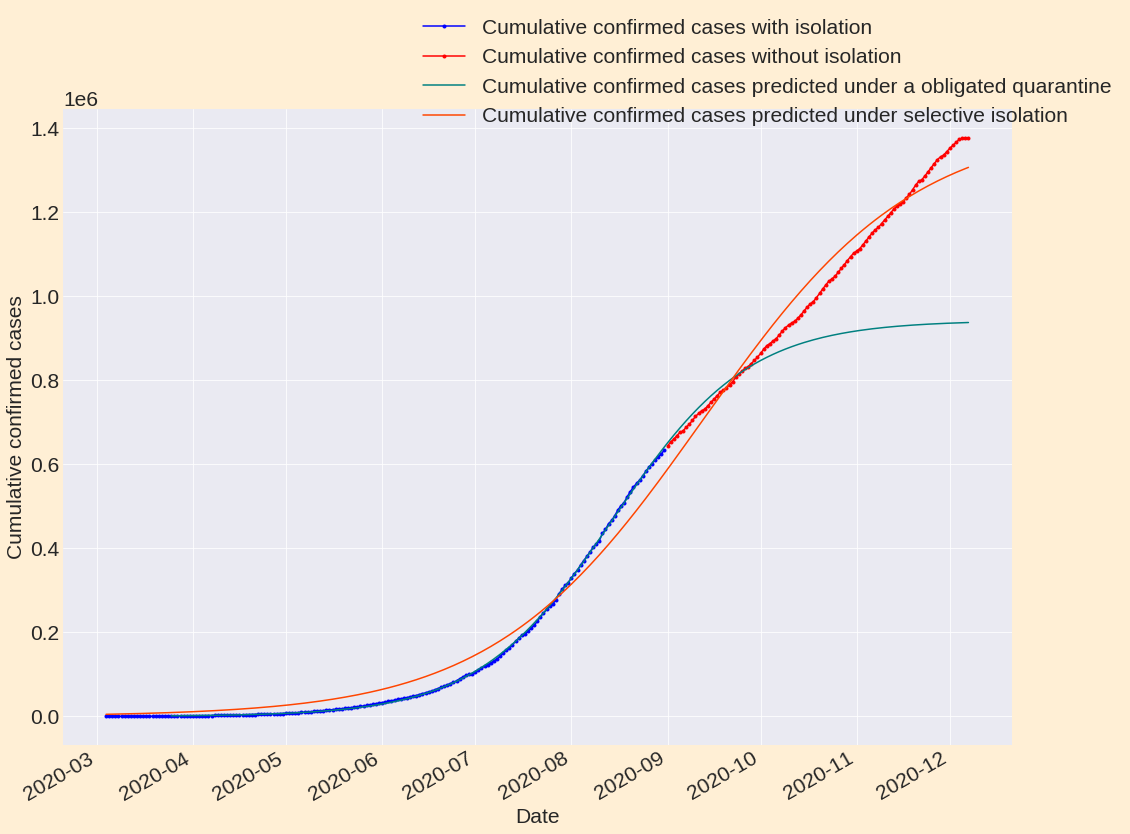

In [21]:
# Ahora pasamos a graficar todos estos comportamientos
fig, ax = plt.subplots()
fig.set_figheight(13)
fig.set_figwidth(17)
fig.patch.set_facecolor("papayawhip")
ax.plot(samples[samples["date"] < selective_isolation]["date"], 
        samples[samples["date"] < selective_isolation]["cumulative_confirmed"],
        c = "blue", label = "Cumulative confirmed cases with isolation", marker = '.')
ax.plot(samples[samples["date"] >= selective_isolation]["date"], 
        samples[samples["date"] >= selective_isolation]["cumulative_confirmed"],
        c = "red", label = "Cumulative confirmed cases without isolation", marker = '.')
ax.plot(obligated_quarantine_data["date"],
       obligated_quarantine_data["cumulative_confirmed"], 
        c = "teal",label = "Cumulative confirmed cases predicted under a obligated quarantine")
ax.plot(selective_isolation_data["date"],
       selective_isolation_data["cumulative_confirmed"], 
        c = "orangered",label = "Cumulative confirmed cases predicted under selective isolation")
fig.autofmt_xdate()
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative confirmed cases")
fig.legend()
fig.show()

In [22]:
# Podemos notar que aun hay una tendencia al crecimiento con estas medidas
# pero lo mas importante es que podemos afirmar que una cuarentena obligatorio 
# habria sido una mejor medida

#### Decesos acumulados en el tiempo

In [23]:
# ¿Podriamos opinar algo sobre los decesos?
# Pues el mismo modelo podria ser utilizado, veamos como se comporta
query = '''
SELECT date, cumulative_deceased
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE country_name = "Colombia" AND aggregation_level = 0
'''

In [24]:
samples = client.query(query).result().to_dataframe()
samples = samples.dropna()

In [25]:
# Modelo de decesos en el tiempo en cuarentena obligatoria
model_1 = CaseLogisticModel("Colombia", "cumulative_deceased")
model_1.fit(samples.loc[(samples["date"] > obligated_quarantine) & 
                       (samples["date"] < selective_isolation)])

Logistic Model for Colombia has been fited

                    Params and errors:
                    a = 21.780953812207294 +/- 0.06378008639584666
                    b = 134.86714784594625 +/- 0.1754152050117117
                    c = 29781.30188161007 +/- 105.50725553577247
            


In [26]:
# Modelo de decesos en el tiempo en con aislamiento selectivo
model_2 = CaseLogisticModel("Colombia", "cumulative_deceased")
model_2.fit(samples)

Logistic Model for Colombia has been fited

                    Params and errors:
                    a = 32.15816784642957 +/- 0.5153385237355972
                    b = 166.65235376945571 +/- 0.7638821168885507
                    c = 41363.31089790286 +/- 309.9001436785799
            


In [27]:
# Generando datos hasta el dia actual
current_date = str(samples["date"].max())
obligated_quarantine_data = model_1.get_behavior_until_a_date(current_date)
selective_isolation_data = model_2.get_behavior_until_a_date(current_date)

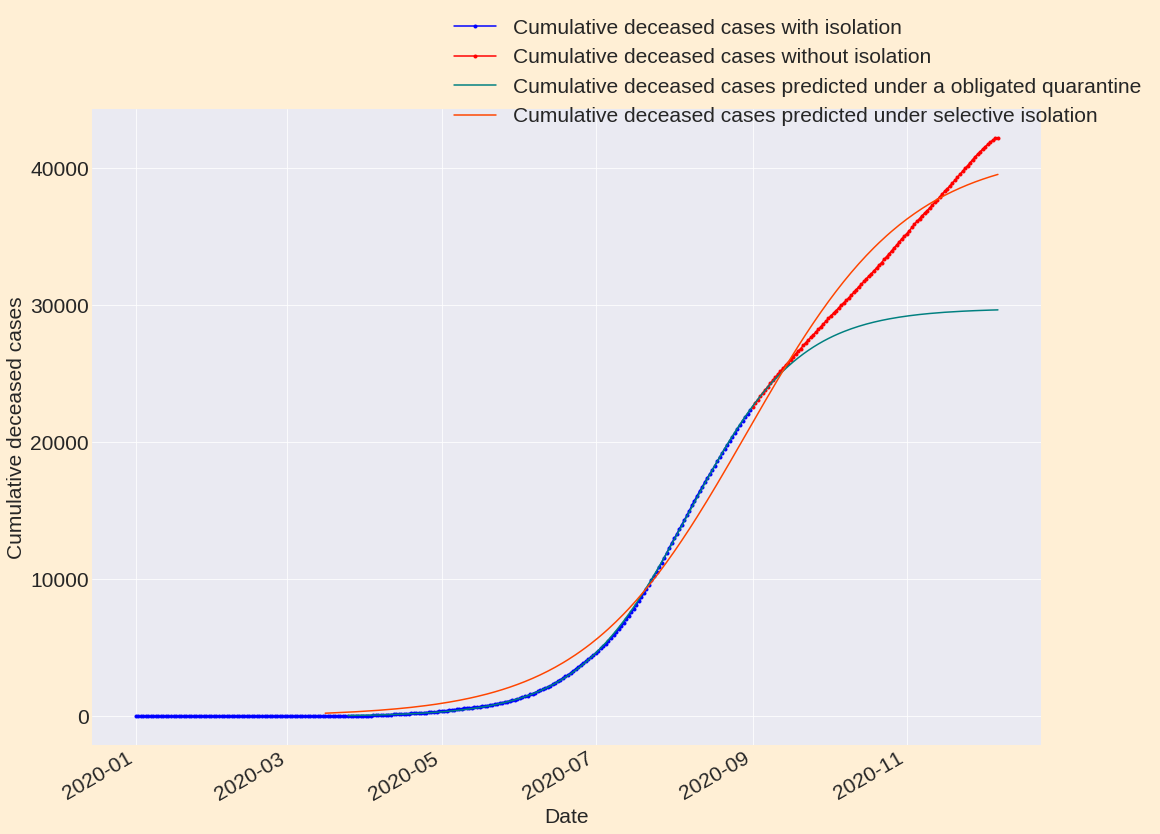

In [28]:
fig, ax = plt.subplots()
fig.set_figheight(13)
fig.set_figwidth(17)
fig.patch.set_facecolor("papayawhip")
ax.plot(samples[samples["date"] < selective_isolation]["date"], 
        samples[samples["date"] < selective_isolation]["cumulative_deceased"],
        c = "blue", label = "Cumulative deceased cases with isolation", marker = '.')
ax.plot(samples[samples["date"] >= selective_isolation]["date"], 
        samples[samples["date"] >= selective_isolation]["cumulative_deceased"],
        c = "red", label = "Cumulative deceased cases without isolation", marker = '.')
ax.plot(obligated_quarantine_data["date"],
       obligated_quarantine_data["cumulative_deceased"], 
        c = "teal",label = "Cumulative deceased cases predicted under a obligated quarantine")
ax.plot(selective_isolation_data["date"],
       selective_isolation_data["cumulative_deceased"], 
        c = "orangered",label = "Cumulative deceased cases predicted under selective isolation")
fig.autofmt_xdate()
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative deceased cases")
fig.legend()
fig.show()

In [29]:
# El comportamiento es similar a los casos acumulados
# lo que implica que vidas pudieron haber sido salvadas
# pero ahora queda.
# ¿ Como se han visto afectados los departamentos?

## ¿Cuales departamentos han sido los mas afectados?

In [30]:
# Es necesario recordar que estamos trabajando con un aggregation_level
# lo que implica que hay que tener cuidado con que variables relacionamos
# los niveles de agregacion clasifican en 
#0: Pais, 
#1: Estado, 
#2: Municipio, 
#3: Localidad que no puede no seguir un orden jerarquico estricto 

In [110]:
# Traemos los datos de los departamentos
query = '''
WITH transitive_table AS 
    (SELECT MAX(cumulative_confirmed) AS confirmed, 
           MAX(cumulative_deceased) AS deceased,
           MAX(cumulative_recovered) AS recovered,
           subregion1_name 
           FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
           WHERE country_name = 'Colombia' AND aggregation_level = 1
           GROUP BY subregion1_name)           
SELECT subregion1_name, (confirmed - deceased - recovered) AS current_cases
FROM transitive_table
ORDER BY current_cases DESC
'''

In [111]:
cases_per_state = client.query(query).result().to_dataframe()

In [33]:
# Poblacion aproximada de los departamentos de Colombia
# obtenido de https://es.wikipedia.org/wiki/Anexo:Departamentos_de_Colombia_por_poblaci%C3%B3n
colombia_population = {
"Bogotá D.C.": 7743955,
"Antioquia": 6677930,
"Valle Del Cauca":	4532152,
"Cundinamarca": 3242999,
"Atlántico": 2722128,
"Santander":2280908,
"Bolívar":2180976,
"Córdoba": 1828947,
"Nariño":1627589,
"Norte de Santander":1620318,
"Cauca":1491937,
"Magdalena":1427026,
"Tolima":1339998,
"Cesar":1295387,
"Boyacá":1242731,
"Huila":1122622,
"Meta":	1063454,
"Caldas":1018453,
"La Guajira":965718,
"Risaralda":961055,
"Sucre":949252,
"Quindío":555401,
"Chocó":544764,
"Casanare":435195,
"Caquetá":	410521,
"Putumayo":359127,
"Arauca":294206,
"Vichada":112958,
"Guaviare":	86657,
"Amazonas":	79020,
"San Andrés and Providencia":63692,
"Guainía":50636,
"Vaupés":	44712}
population_data = pd.DataFrame()
population_data["subregion1_name"] = colombia_population.keys()
population_data["population"] = colombia_population.values()
population_data = population_data.set_index("subregion1_name")

In [34]:
# Unimos la poblacion y los casos actuales
cases_per_state = cases_per_state.join(population_data, on="subregion1_name")

In [35]:
# Calculamos la densidad de casos, es decir, la cantidad de casos por millon de personas
cases_per_state["cases_density"] = (cases_per_state["current_cases"] / cases_per_state["population"])*1000000

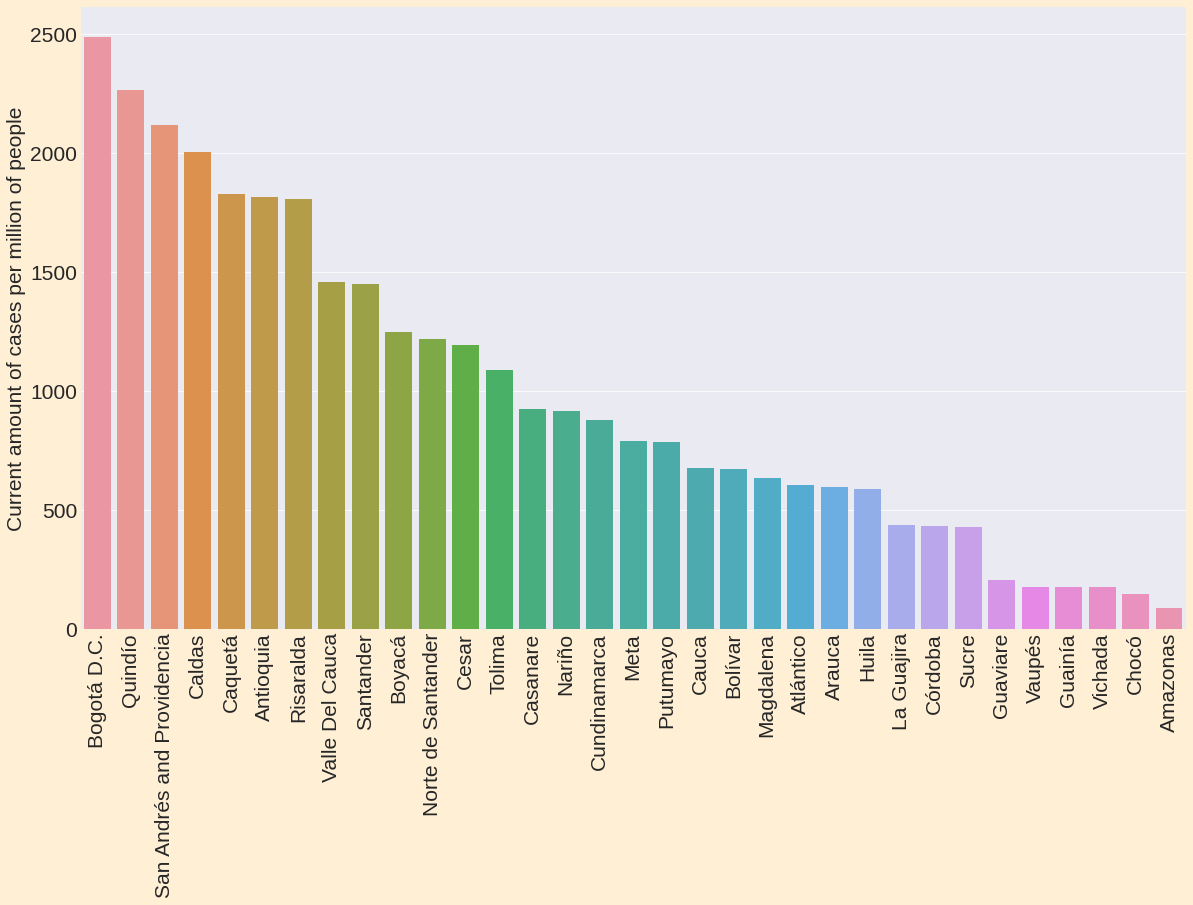

In [36]:
ordered_set = cases_per_state.sort_values("cases_density",ascending=False)
fig, ax = plt.subplots()
fig.set_figheight(13)
fig.set_figwidth(17)
fig.patch.set_facecolor("papayawhip")
sns.barplot(x=ordered_set["subregion1_name"],y=ordered_set["cases_density"], ax = ax)
ax.set_xticklabels(ordered_set["subregion1_name"], rotation=90)
ax.set_xlabel("")
ax.set_ylabel("Current amount of cases per million of people")
plt.tight_layout()

In [37]:
# Podemos notar que los departamentos mas afectados para el momento del analisis son:
# Bogota D.C.
# Quindio
# San Andrés and Providencia
# Caldas
# Caquetá
# Bogota es la capital por lo que no es sorprendente que la mayor densidad de casos se 
# encuentre alli.
# Sin embargo, Quindio, Caquetá, San Andres and Providencia son departamentos con baja poblacion
# por eso al tener incluso menos del 10 % de los casos de Bogota, tambien se ven afectados
ordered_set.head()
# Ahora, a nivel general ¿Que otras variables estan afectando este crecimiento en casos?

,subregion1_name,current_cases,population,cases_density
0,Bogotá D.C.,19268,7743955,2488.134293
14,Quindío,1258,555401,2265.030131
26,San Andrés and Providencia,135,63692,2119.575457
5,Caldas,2043,1018453,2005.983585
19,Caquetá,750,410521,1826.946734


## Efecto de las variables del comportamiento de Colombia sobre las variables epidemiologicas


In [ ]:
# Para encontrar otras relaciones se utilizara el predictive power score (PPS)
# esto permite obtener informacion sobre como se correlacionan las variables
# en el caso de que las correlaciones de pearson, spearman y kendall 
# no encuentren un dato resaltante, el cual es nuestro caso.
# Un detalle importante es que el PPS es asimetrico, por lo que el poder de prediccion
# de una variables X respecto a Y es diferente al PPS de Y respecto a X,
# ademas es data-type agnostic por lo que la menera en la que se obtiene el PPS
# se ajusta al tipo de dato tanto categorico como numerico 
!pip install ppscore
import ppscore

In [100]:
# Traemos datos de las variables que nos interesan para colombia
query = '''
SELECT date, new_confirmed, 
       new_deceased, new_recovered,new_tested, 
       cumulative_confirmed, cumulative_deceased,
       cumulative_recovered, cumulative_tested, mobility_transit_stations,
       mobility_retail_and_recreation, mobility_grocery_and_pharmacy,
       mobility_parks, mobility_residential, mobility_workplaces, latitude,
       longitude, location_geometry, average_temperature_celsius,
       minimum_temperature_celsius, maximum_temperature_celsius,
       rainfall_mm 
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE country_name = 'Colombia' AND aggregation_level = 0
'''

In [101]:
results = client.query(query).result().to_dataframe()

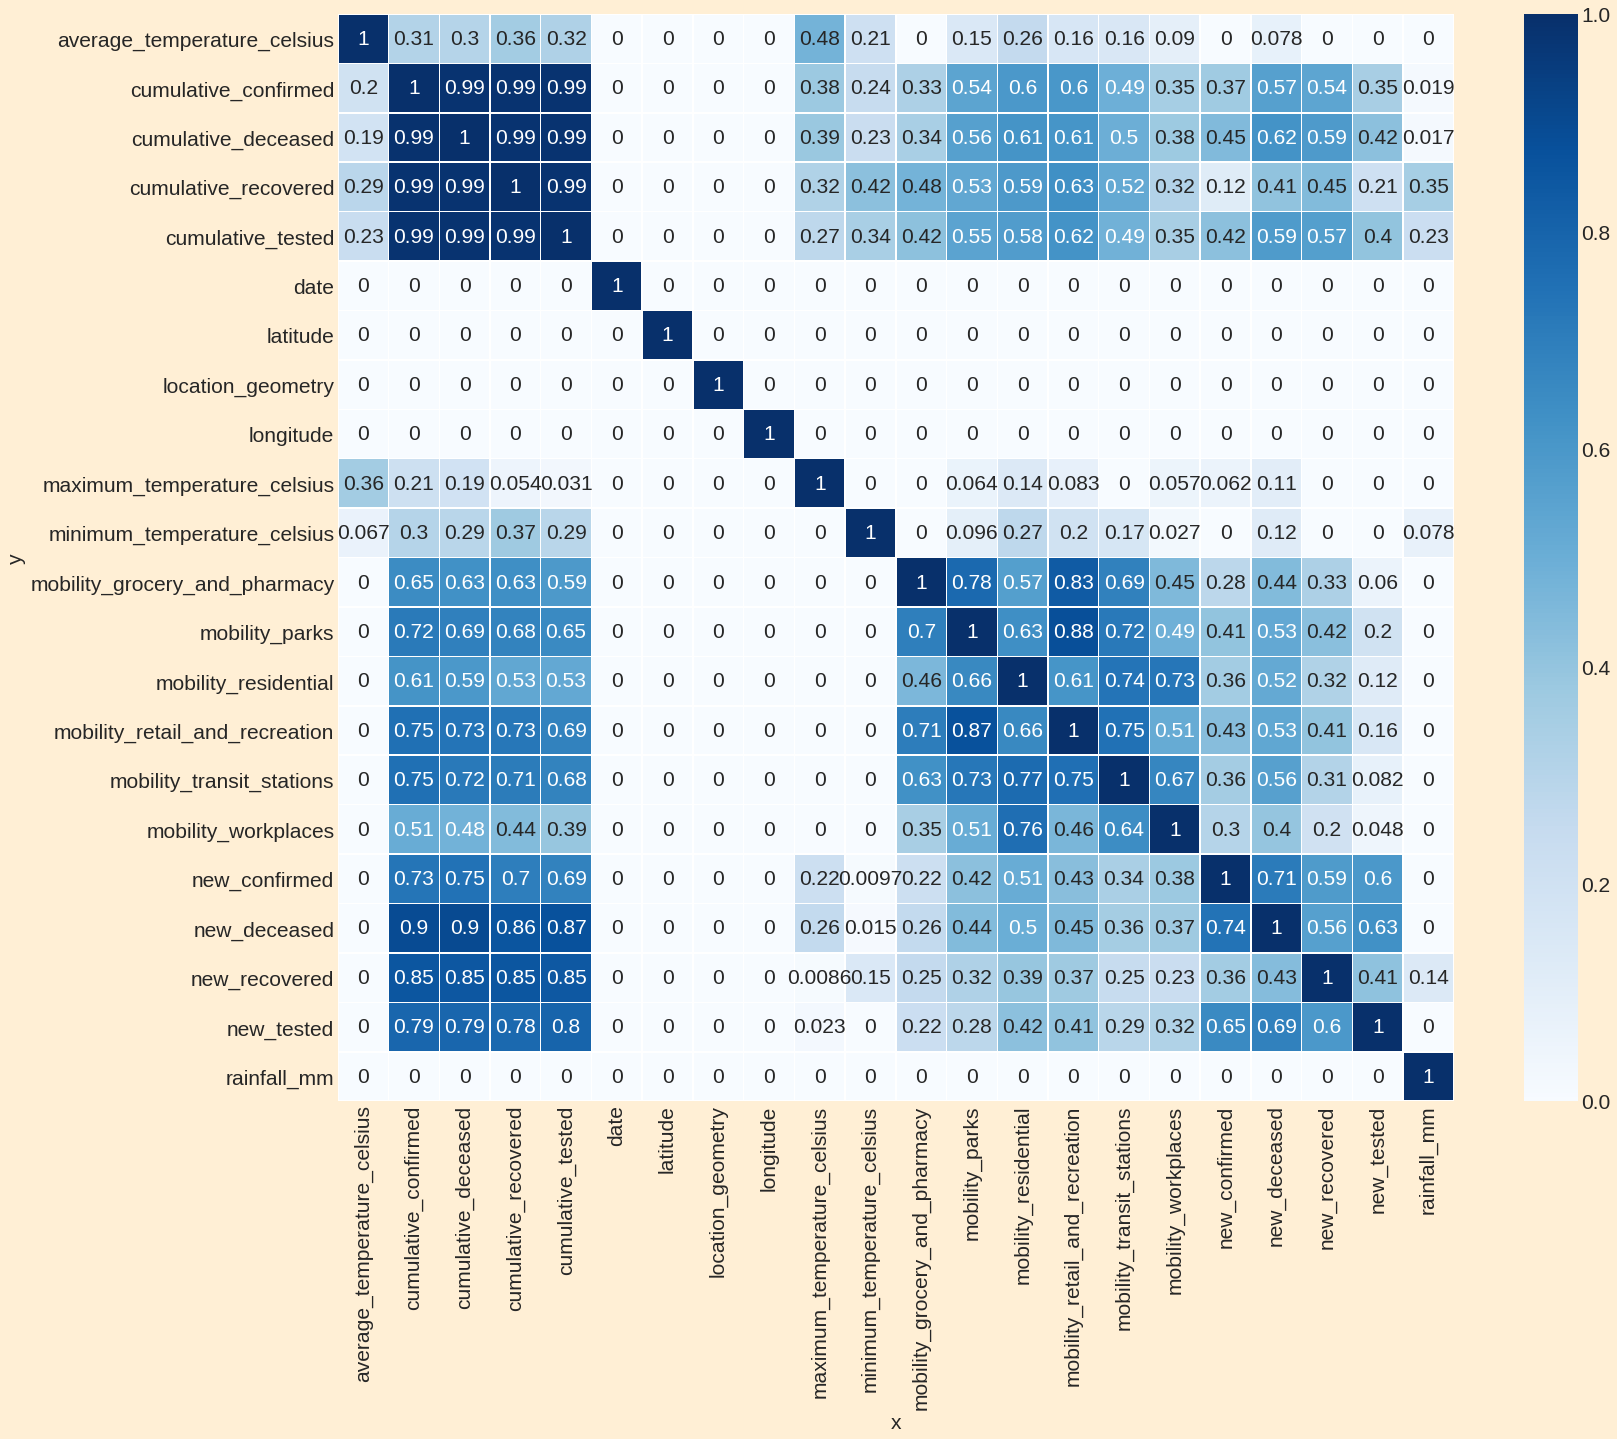

In [102]:
# Se construye un plot con los PPS del tipo heatmap para 
# ver las relaciones entre las variables
matrix_df = ppscore.matrix(results)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(25)
fig.patch.set_facecolor("papayawhip")
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, ax = ax)

In [ ]:
# La zona de interes la superior derecha dado que se intenta predecir las variables epidemiologicas
# Se observa:
# La actividad mobility_parks, mobility_residentials, 
# mobility_trans_stations y mobility_retail_and_recreation
# Impactan directamente a los casos, decesos y recuperados acumulados
# Ademas podemos notar que la temperatura y sus variaciones no tienen
# mucho efecto en las variables epidemiologicas
# veamos el comportamiento mobility_retail_and_recreation y cumulative_confirmed
# para ver si esto es real.

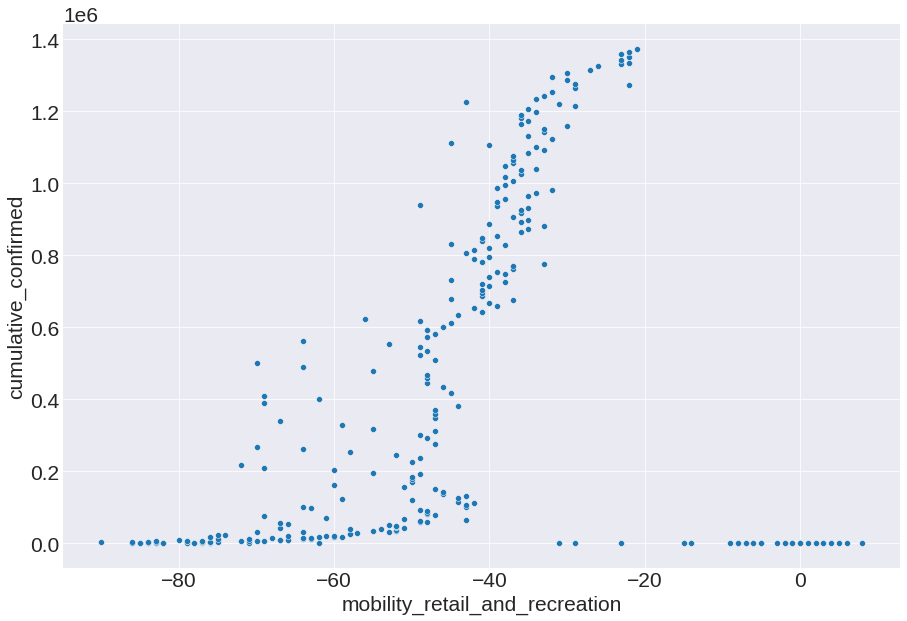

In [108]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
sns.scatterplot(x = results["mobility_retail_and_recreation"], 
                y = results["cumulative_confirmed"], 
                ax = ax)

In [ ]:
# Podemos notar que si hay una patron alli,
# Logicamente mientras exista mayor mobilidad de las personas, 
# los casos acumulados seguiran aumentando
# Un estudio mas a fondo de las relaciones entre estas features podria
# llevarnos a mejores modelos aplicando machine learning
# Es necesario resaltar que la mobilidad es una variable relativa respecto a la mobilidad
# que tenian las personas del pais antes de la pandemia y durante la pandemia,
# por eso existe entre -100 y 0, dado que -100 implica cuarentena obligatoria
# y 0 completa libertad como si no hubiera pandemia
# ¿Que podemos concluir de este analisis?

## Conclusiones

Se puede concluir que el gobierno no ha manejado de la mejor manera los problemas que ha traido la pandemia y que en vista de las decisiones que se tomen, los resultados podrian generar muchos infectados y muchos decesos.
Tambien se puede acotar que aunque Bogota es de los primeros departamentos con mayor densidad de casos, departamentos mas pequeños estan siendo afectados, esto podria deberse a las actividades economicas que llevan a cabo.
Esta investigacion es del tipo descriptiva y puede ser extendida utilizando tecnicas de modelado con machine learning para predecir mejor las variables epidemiologicas, ademas de ser extendida de manera granular atendiendo la informacion mas detallada de departametos y ciudades.
